In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
base_Edu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Edu.parquet")
base_Edu

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1306435320134834461,0,-4,2021-02-25 10:11:13.000000,7,0,0,0,11,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
199996,5732789662758255879,0,0,2017-12-06 15:46:14.000000,45,0,0,0,7,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199997,3325713948509922176,17,9,2019-07-21 18:24:08.000000,229,0,0,0,83,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199998,7446387329160512320,68,57,2021-10-28 19:09:58.000000,172,0,242,0,310,120,...,0,0,0,15,0,0,0.0,100.0,0.0,0.0


In [3]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [4]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [5]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [6]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [7]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [8]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [9]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [10]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [11]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

## ACP

In [12]:
#base_acp=base_Edu.select_dtypes(include=["int","float"]).drop(columns="unique_learner_id")

In [13]:
#pip install ploty

In [14]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
 
# # Étape 1 : Identifier les colonnes catégorielles
# #base_acp=base_Edu.select_dtypes('float').drop(columns="unique_learner_id")
# categorical_columns = base_acp.select_dtypes(include=['object', 'category']).columns
# numerical_columns = base_acp.select_dtypes(include=['int64', 'float64']).columns

# # Étape 2 : Encodage One-Hot des colonnes catégorielles
# encoder = OneHotEncoder(sparse_output=False)
# encoded_categorical = encoder.fit_transform(base_acp[categorical_columns])
# modalities = encoder.get_feature_names_out(categorical_columns)  # Noms des modalités encodées

# # Étape 3 : Combiner les colonnes numériques et encodées
# import numpy as np
# if numerical_columns.any():
#     combined_data = np.hstack((base_acp[numerical_columns].values, encoded_categorical))
# else:
#     combined_data = encoded_categorical

# #Centrer et réduire les variables 
# scaler=StandardScaler()
# base_acp=scaler.fit_transform(base_acp)

# # Étape 4 : Application de l'ACP
# pca = PCA(n_components=10)
# components = pca.fit_transform(combined_data)
 
# # Créer un DataFrame avec les trois premiers axes
# pca_df = pd.DataFrame(
#     components,
#     columns=['PCA1', 'PCA2', 'PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']
# )

# # Étape 5 : Visualisation des composantes principales
# plt.figure(figsize=(8, 6))
# plt.scatter(components[:, 0], components[:, 1], s=100, alpha=0.7, c='blue')
# plt.title('Analyse en composantes principale (ACP)')
# plt.xlabel('Composante principale 1')
# plt.ylabel('Composante principale 2')
# plt.grid()
# plt.show()

# # Étape 6 : Variance expliquée par chaque composante
# print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

In [15]:
# # Étape 3 : Récupérer la variance expliquée
# explained_variance = pca.explained_variance_ratio_

# # Afficher la variance expliquée par axe
# for i, var in enumerate(explained_variance, start=1):
#     print(f"Axe {i}: {var * 100:.2f}% de variance expliquée")


# import matplotlib.pyplot as plt

# # Graphique de la variance expliquée
# plt.figure(figsize=(8, 5))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='blue', alpha=0.7)
# plt.title('Variance expliquée par axe')
# plt.xlabel('Axe')
# plt.ylabel('Variance expliquée (%)')
# plt.xticks(range(1, len(explained_variance) + 1))
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

## FAMD

In [16]:
#!pip install prince

In [17]:
# base_Edu.info()
# base_Edu_sample = base_Edu.sample(n=5000, random_state=42)

In [18]:
# import pandas as pd
# from prince import FAMD


# # Identifier les types de colonnes
# numeric_cols = base_Edu_sample.select_dtypes(include=['int64', 'float64']).columns
# categorical_cols = base_Edu_sample.select_dtypes(include=['category', 'object', 'bool']).columns

# # Note : Les colonnes datetime64 ne sont pas directement utilisables dans la FAMD.
# # On pourrait les transformer si elles ont du sens (par exemple en extraire l'année, le mois, etc.)
# datetime_cols = base_Edu_sample.select_dtypes(include=['datetime64']).columns
# #une tab
# if len(datetime_cols) > 0:
#     print("Transformation des colonnes datetime")
#     for col in datetime_cols:
#         base_Edu_sample[col + '_year'] = base_Edu_sample[col].dt.year
#         base_Edu_sample[col + '_month'] = base_Edu_sample[col].dt.month
#         base_Edu_sample[col + '_day'] = base_Edu_sample[col].dt.day
#     base_Edu_sample = base_Edu_sample.drop(columns=datetime_cols)

# # Application de la FAMD
# famd = FAMD(n_components=378, random_state=42)  # Conserver 10 dimensions
# print("je suis là")
# base_Edu_reduced = famd.fit_transform(base_Edu_sample)
# print('jai fini')
# # Résultat : DataFrame réduit
# base_Edu_reduced = pd.DataFrame(base_Edu_reduced, columns=[f"FAMD_{i+1}" for i in range(base_Edu_reduced.shape[1])])

# # Afficher les premières lignes
# print(base_Edu_reduced.head())

## Auto-Encoder

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base q qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de la moité des observations pour notre Auto-Encoder. 

In [19]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

Les résultats obtenus avec un Auto-Encoder dépendent de la valeur de la dimension de l'espace latent choisi c'est à dire le nombre de variables de sorties. Dans un premier temps, nous réaliserons donc l'Auto-Encoder pour plusieurs valeurs de l'hyperparamètre (k allant de 1 à 20) et au vu des résultats déciderons d'une valeur optimale du paramètre 

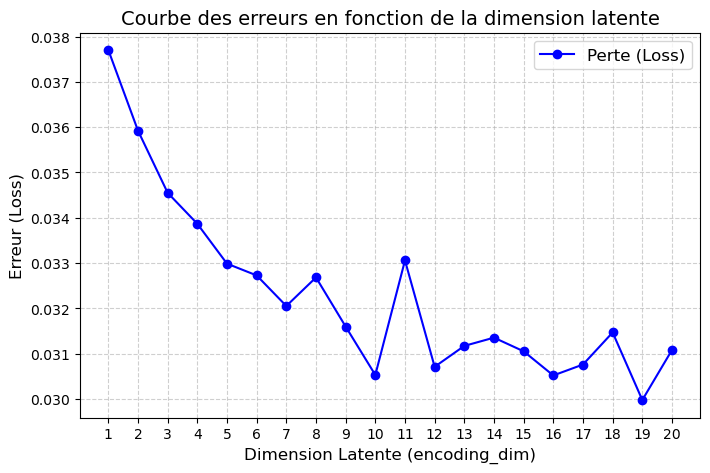

In [20]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
input_dim = x_train.shape[1]

# === 3. Entraînement des autoencodeurs pour différentes dimensions latentes ===
results = []

for encoding_dim in range(1, 21):  # Tester des dimensions latentes de 1 à 20
    # Initialisation déterministe des poids
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

    # Construction de l'autoencodeur
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(256, activation='relu', kernel_initializer=initializer)(input_img)
    Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
    encoded = Dense(encoding_dim, activation='relu', kernel_initializer=initializer)(Hidden2)

    Hidden_output1 = Dense(128, activation='sigmoid', kernel_initializer=initializer)(encoded)
    Hidden_output2 = Dense(256, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output2)

    # Créer le modèle
    autoencoder = Model(input_img, decoded)

    # Compiler le modèle
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entraîner le modèle
    history = autoencoder.fit(
        x_train, x_train,
        epochs=50,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=0
    )

    # Récupérer la perte de validation à la dernière époque
    final_loss = history.history['val_loss'][-1]

    # Ajouter la dimension et la perte au tableau des résultats
    results.append({'encoding_dim': encoding_dim, 'loss': final_loss})

# === 4. Visualisation des résultats ===
df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(df_results['encoding_dim'], df_results['loss'], marker='o', linestyle='-', color='b', label='Perte (Loss)')
plt.xlabel('Dimension Latente (encoding_dim)', fontsize=12)
plt.ylabel('Erreur (Loss)', fontsize=12)
plt.title('Courbe des erreurs en fonction de la dimension latente', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_results['encoding_dim'])
plt.legend(fontsize=12)
plt.show()


Le graphique précédent représente la courbe des erreurs en fonctions des valeurs de l'hyperparamètre k allant de 1 à 20. Nous choisissons ici la valeur k=10. Au-delà de 10 dimensions, l'ajout de nouvelles dimensions n'apporte qu'une faible amélioration à la performance. Ainsi, choisir k = 10 permet de conserver les dimensions les plus informatives tout en réduisant la complexité du modèle. Cette valeur offre aussi un compromis entre interprétation raisonnable des variables latentes et reconstruction efficace des données. 

Epoch 1/50
83/83 [==============================] - 2s 16ms/step - loss: 0.0719 - val_loss: 0.0483
Epoch 2/50
83/83 [==============================] - 1s 12ms/step - loss: 0.0446 - val_loss: 0.0407
Epoch 3/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0410 - val_loss: 0.0396
Epoch 4/50
83/83 [==============================] - 1s 16ms/step - loss: 0.0404 - val_loss: 0.0392
Epoch 5/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0401 - val_loss: 0.0389
Epoch 6/50
83/83 [==============================] - 1s 12ms/step - loss: 0.0399 - val_loss: 0.0387
Epoch 7/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0399 - val_loss: 0.0386
Epoch 8/50
83/83 [==============================] - 1s 12ms/step - loss: 0.0396 - val_loss: 0.0385
Epoch 9/50
83/83 [==============================] - 1s 11ms/step - loss: 0.0395 - val_loss: 0.0384
Epoch 10/50
83/83 [==============================] - 1s 12ms/step - loss: 0.0393 - val_loss: 0.0380
Epoch 11/

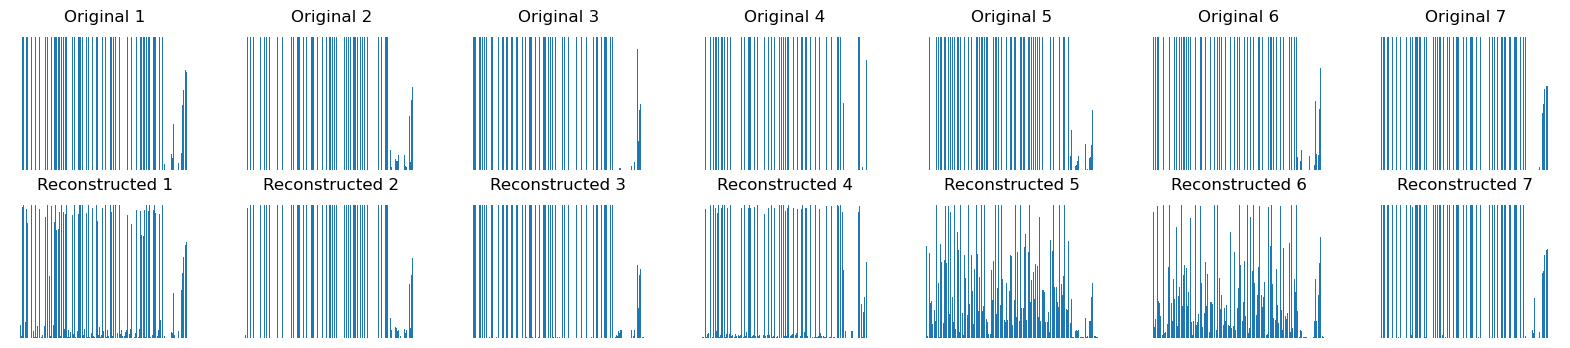

Erreur moyenne de reconstruction : 0.0305


In [21]:
# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 10

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# Encodeur
input_img = Input(shape=(input_dim,))
Hidden1 = Dense(256, activation='relu', kernel_initializer=initializer, name="Hidden1")(input_img)
Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer, name="Hidden2")(Hidden1)
encoded = Dense(encoding_dim, activation='relu', kernel_initializer=initializer, name="encoded")(Hidden2)

# Décodeur
Hidden_output1 = Dense(128, activation='sigmoid', kernel_initializer=initializer)(encoded)
Hidden_output2 = Dense(256, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output2)

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 3. Taux d'information conservée ===
# Erreur de reconstruction (MSE)
mse = np.mean((x_test - decoded_imgs) ** 2)

# Variance des données d'origine
variance_original = np.var(x_test)

# Taux d'information conservée
information_retained = 1 - (mse / variance_original)
print(f"Taux d'information conservée : {information_retained * 100:.2f}%")

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


Le graphIque précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=10 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=10 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

In [22]:
autoencoder.save("autoencoder_model.h5")

Nous allons maintenant passer à l'interprétation des nos 10 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. Ce effet sera utiliser pour déterminer quelles variables de départ influencent le plus quelle variable latente 

In [23]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test)  # Analyser un sous-échantillon de test

d:\Anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [70]:
# # Vérification de la structure des valeurs SHAP
# print(f"Shape of shap_values: {len(shap_values)} dimensions latentes.")
# print(f"Shape of shap_values for first latent variable: {shap_values[0].shape}")
# print(f"Shape of x_test: {x_test.shape}")
# print(np.shape(shap_values))

In [49]:
import pandas as pd

# Pour chaque dimension latente
for i in range(10):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(10))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                          0.624598
is_first_exam_success_2                          0.423936
securite_number_of_activities                    0.350437
is_interested_in_automatic_0                     0.307833
environnement_number_of_activities               0.298985
is_aac_0                                         0.287435
prendre_quitter_vehicule_number_of_activities    0.281906
mecanique_equipements_number_of_activities       0.274721
has_passed_theory_exam_1                         0.243512
pct_no_objective_weeks                           0.240150
dtype: float64
Les variables les plus influentes pour la 2-ème dimension latente:
pct_no_objective_weeks                               1.705425
pct_study_objective_not_reached                      1.063851
score_pct__last_location_of_minimum                  0.736420
score_pct__first_location_of_minimum                 0.556224
choice_01_b6a4bca6-eb45

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes. Mais cette sortie serait plus intéressante sous forme de graphique.

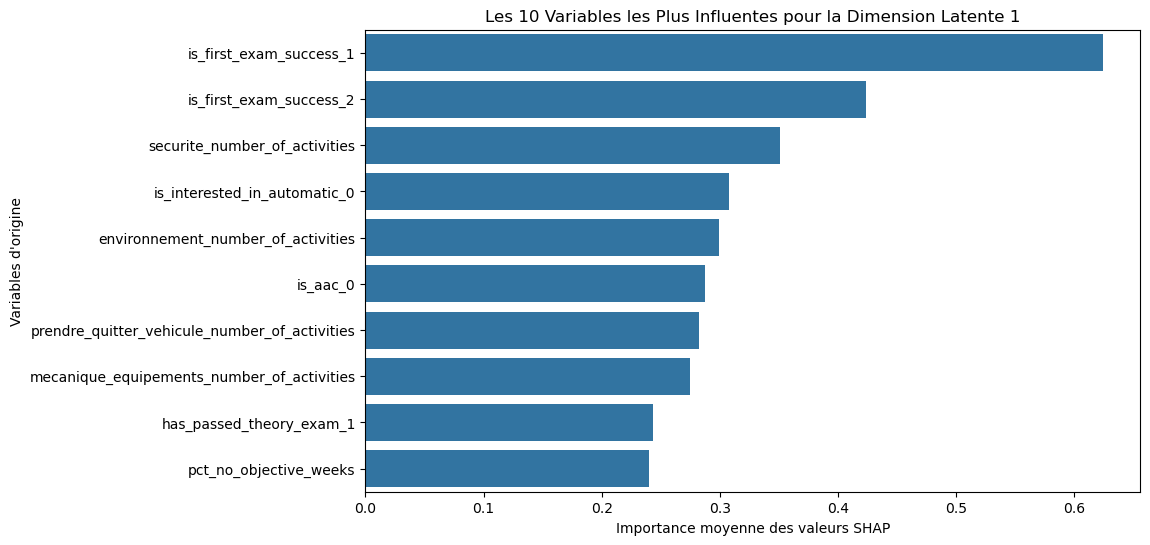

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=0 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette première dimension latente semble capturer une combinaison entre la **réussite à l’examen du permis de conduire**, l’**engagement dans la formation**, et une possible **distinction entre candidats avec ou sans information sur leur succès**. En effet, les variables les plus influentes incluent **is_first_exam_success_1 et is_first_exam_success_2**, qui indiquent si un candidat a réussi son premier examen, ainsi que plusieurs variables représentant le **nombre d’activités effectuées** dans des domaines liés à la conduite (sécurité, mécanique, environnement, etc.). La présence simultanée des deux modalités  suggère que cette dimension ne se contente pas de différencier ceux qui ont réussi ou échoué, mais pourrait aussi refléter un **effet des valeurs manquantes (NA)**, distinguant les candidats dont la réussite est renseignée de ceux pour lesquels l’information est absente. Enfin, la corrélation avec le **pourcentage de semaines sans objectif** pourrait indiquer que cette dimension reflète aussi **le degré d’investissement et la régularité dans la préparation**.

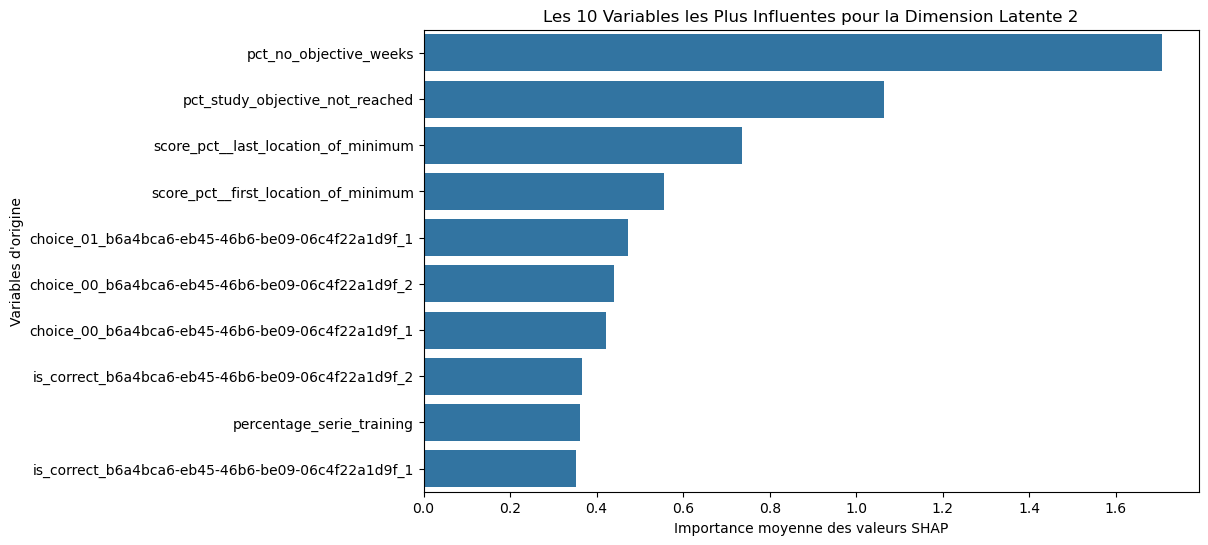

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=1 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette deuxième dimension latente semble être fortement liée à la **gestion des objectifs d'apprentissage et à la performance aux tests**. En effet, les variables les plus influentes incluent **pct_no_objective_weeks** et **pct_study_objective_not_reached**, qui traduisent le pourcentage de semaines sans objectif et le taux d’objectifs d’apprentissage non atteints, suggérant que cette dimension reflète **le niveau d’assiduité et de structuration dans la préparation**. De plus, les variables **score_pct__last_location_of_minimum** et **score_pct__first_location_of_minimum** semblent indiquer des tendances de performance au fil du temps, ce qui pourrait signifier que cette dimension capture aussi **l’évolution des résultats** pendant la formation. Enfin, la présence de plusieurs variables liées à des **réponses spécifiques à des questions d’examen (is_correct_… et choice_….)**, après encodage OneHot, suggère que cette dimension pourrait différencier **les candidats qui réussissent certaines questions clés** de ceux qui échouent, voire **mettre en évidence une tendance à se tromper sur certains types de questions**. Ainsi, cette dimension latente pourrait être interprétée comme une **mesure de la rigueur dans l’apprentissage et de la progression dans la maîtrise des connaissances requises pour l’examen**.

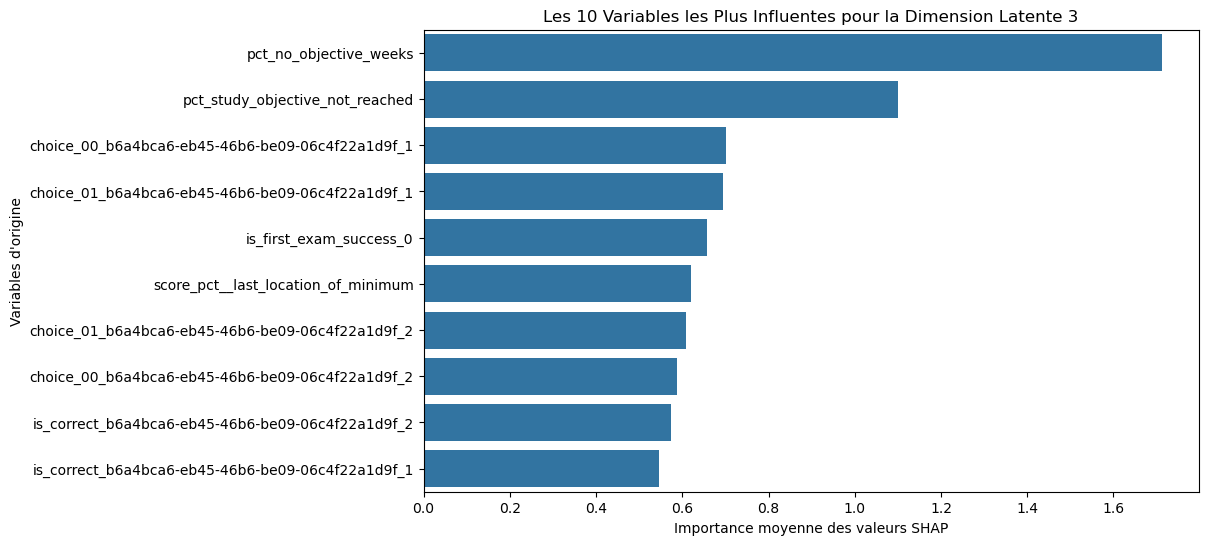

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=2 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette troisième dimension latente semble capturer une combinaison entre **le suivi des objectifs, la réussite aux tests et l’échec à l’examen final**. Les variables **pct_no_objective_weeks** et **pct_study_objective_not_reached**, qui expriment le pourcentage de semaines sans objectif et le taux d’objectifs non atteints, dominent une nouvelle fois l’influence, suggérant un lien fort avec le **niveau d’engagement dans la préparation**. Cependant, à la différence de la deuxième dimension, on observe ici une forte présence de **is_first_exam_success_0**, qui indique l’échec à l’examen du permis, ce qui suggère que cette dimension pourrait opposer **les candidats qui ont échoué à ceux qui ont mieux réussi**. De plus, la présence marquée de variables liées à des **choix et réponses aux tests (choice_… et is_correct_…)** indique que cette dimension pourrait aussi traduire **un certain type de comportement face aux questions d’examen**, par exemple une tendance à donner des réponses incorrectes sur des questions spécifiques. Enfin, le score lié à la **localisation du minimum de performance** renforce l’idée que cette dimension reflète **un parcours d’apprentissage moins efficace, avec des difficultés persistantes menant potentiellement à l’échec final**. Ainsi, cette dimension pourrait être interprétée comme un **indicateur d’échec potentiel, intégrant à la fois un manque d’investissement dans la préparation et des difficultés dans les tests et l’examen final**.

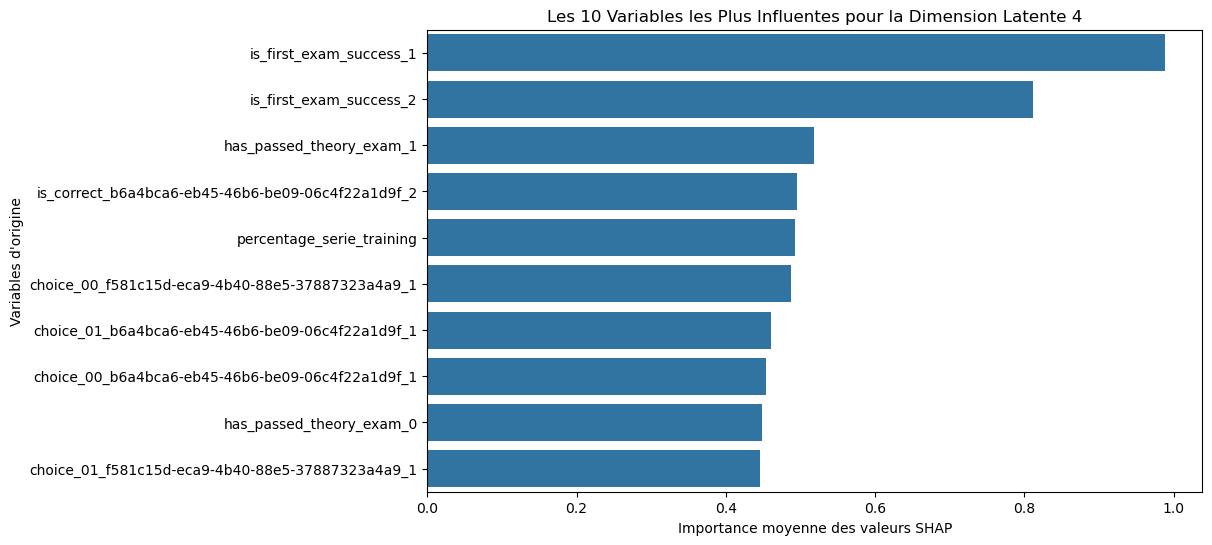

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=3 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette quatrième dimension latente semble refléter la **réussite aux examens du permis de conduire**, aussi bien théorique que pratique. Les variables les plus influentes, comme **is_first_exam_success_1, is_first_exam_success_2** et **has_passed_theory_exam_1**, indiquent une forte association avec le succès aux épreuves. De plus, la présence de variables liées aux réponses aux tests et aux entraînements suggère que cette dimension capture aussi **l’impact de la préparation sur la performance finale**. Elle semble ainsi opposer les candidats ayant bien réussi leurs examens à ceux ayant rencontré plus de difficultés.

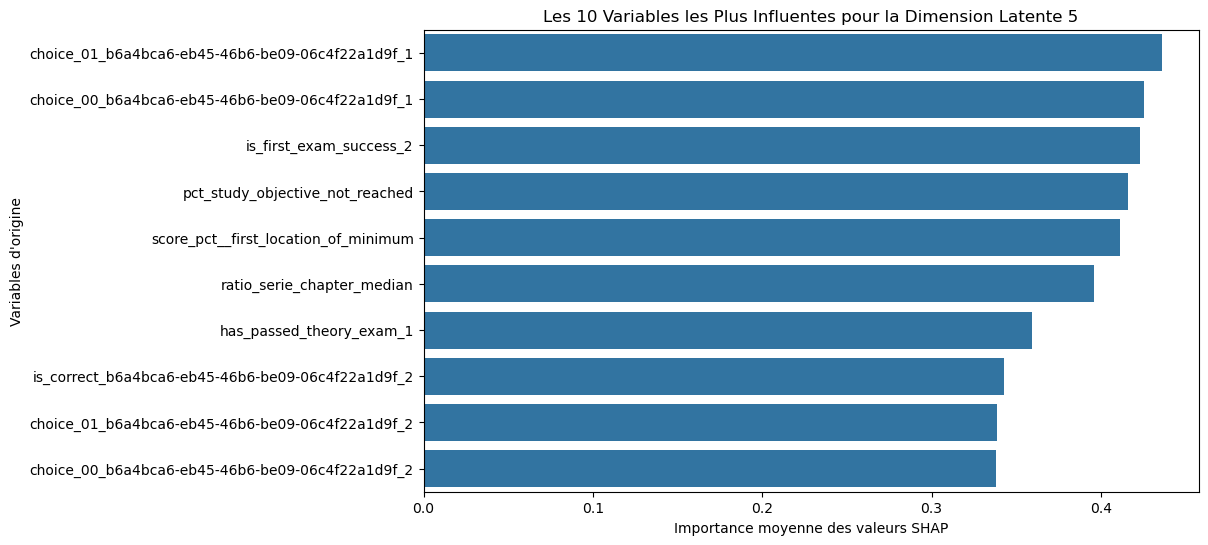

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=4 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette cinquième dimension latente semble être liée à **la manière dont les candidats interagissent avec les tests et leur progression dans l’apprentissage**. La présence dominante de variables associées aux **choix de réponse et à leur correction** indique que cette dimension capture un **schéma de réponse spécifique aux questions du test**. De plus, l’influence de **pct_study_objective_not_reached** et **ratio_serie_chapter_median** suggère qu’elle reflète également **le niveau d’atteinte des objectifs d’étude et la régularité dans l’entraînement**. Enfin, la présence de **is_first_exam_success_2** et **has_passed_theory_exam_1** montre une possible connexion avec la réussite aux examens, bien que moins marquée que dans la quatrième dimension. Cette composante pourrait ainsi représenter **une combinaison entre le style de réponse aux tests et l’engagement dans la préparation**.

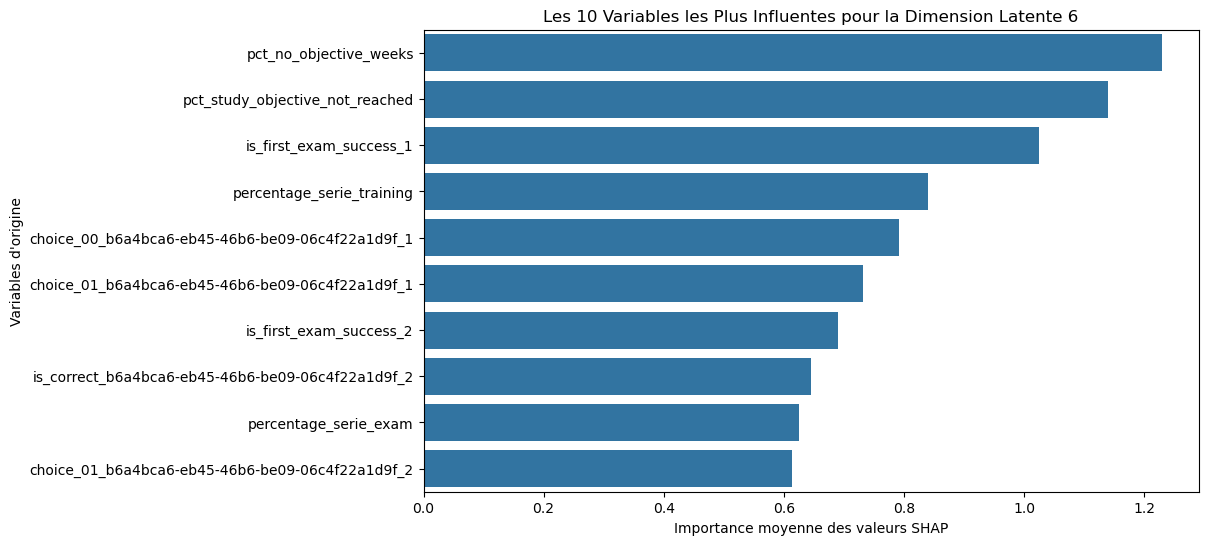

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=5 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette sixième dimension latente semble refléter **l’engagement dans la préparation et son impact sur la réussite aux examens**. Les variables **pct_no_objective_weeks** et **pct_study_objective_not_reached** indiquent dans quelle mesure les candidats ont atteint leurs objectifs d’étude, tandis que **percentage_serie_training** et **percentage_serie_exam** traduisent leur niveau de pratique des séries d’entraînement et d’examen. Par ailleurs, la présence des variables **is_first_exam_success_1 et is_first_exam_success_2** suggère une corrélation entre cet engagement et la réussite à l’examen. Enfin, l’influence des variables liées aux réponses aux tests indique que cette dimension capte aussi **le lien entre la manière dont les candidats interagissent avec les questions et leurs performances globales**.

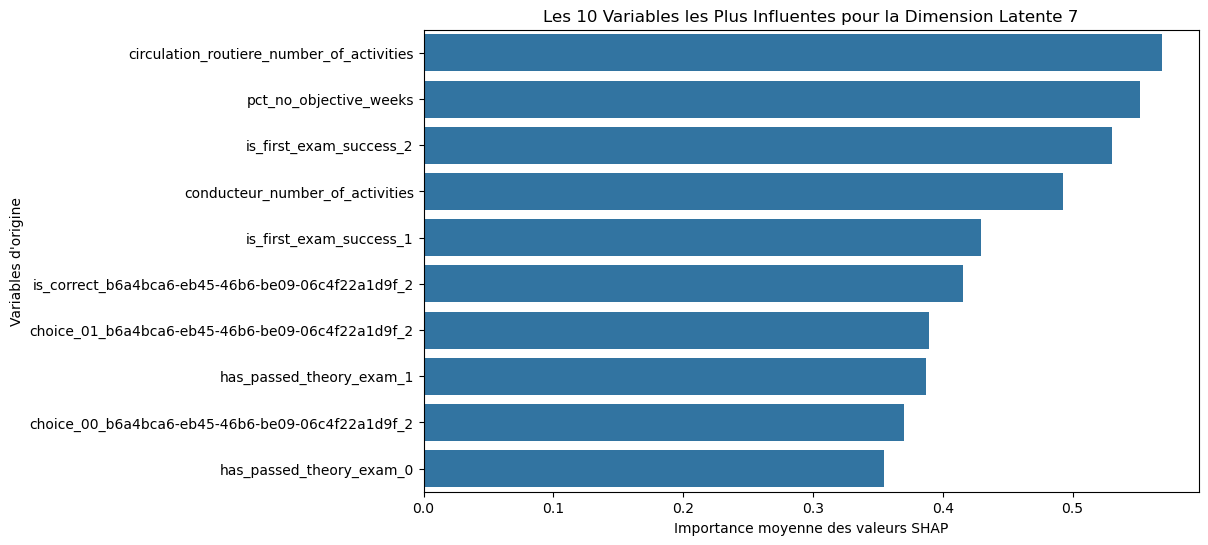

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=6 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette septième dimension latente semble capturer **l’implication dans les activités pratiques et leur lien avec la réussite aux examens**. La forte influence de **circulation_routiere_number_of_activities** et **conducteur_number_of_activities** suggère une connexion avec la participation aux exercices liés à la conduite et à la circulation routière. Par ailleurs, la présence de **pct_no_objective_weeks** indique que cette dimension intègre également **le suivi des objectifs d’apprentissage**. Enfin, la corrélation avec **is_first_exam_success_1, is_first_exam_success_2 et has_passed_theory_exam_1** laisse penser que cette composante reflète **dans quelle mesure l’expérience pratique influence la réussite à l’examen du permis de conduire**.

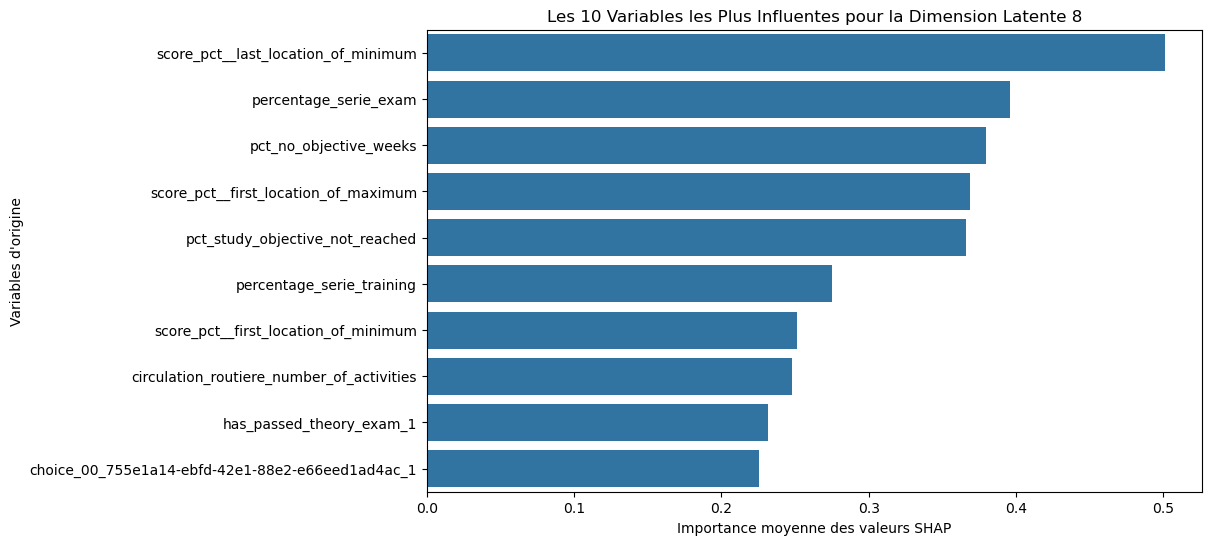

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=7 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette huitième dimension latente semble être liée à **l’efficacité de l’entraînement et à la gestion des objectifs d’étude**. Les variables **score_pct__last_location_of_minimum**, **score_pct__first_location_of_maximum** et **score_pct__first_location_of_minimum** suggèrent que cette dimension capture **les points d’inflexion dans la performance durant l’entraînement**, notamment les moments où les résultats sont soit au plus bas, soit au plus élevé. La présence de **pct_no_objective_weeks** et **pct_study_objective_not_reached** reflète également l’importance des **objectifs d’étude non atteints**, ce qui peut indiquer une difficulté à atteindre les objectifs fixés. De plus, les variables telles que **percentage_serie_exam** et **percentage_serie_training** montrent que la dimension est influencée par **le degré de préparation aux séries d'examen et d'entraînement**, mettant en lumière l'impact de ces efforts sur la performance. Enfin, la présence de **circulation_routiere_number_of_activities** et d'une variable liée aux choix dans les tests indique un lien avec **l’implication pratique dans les activités de conduite**.

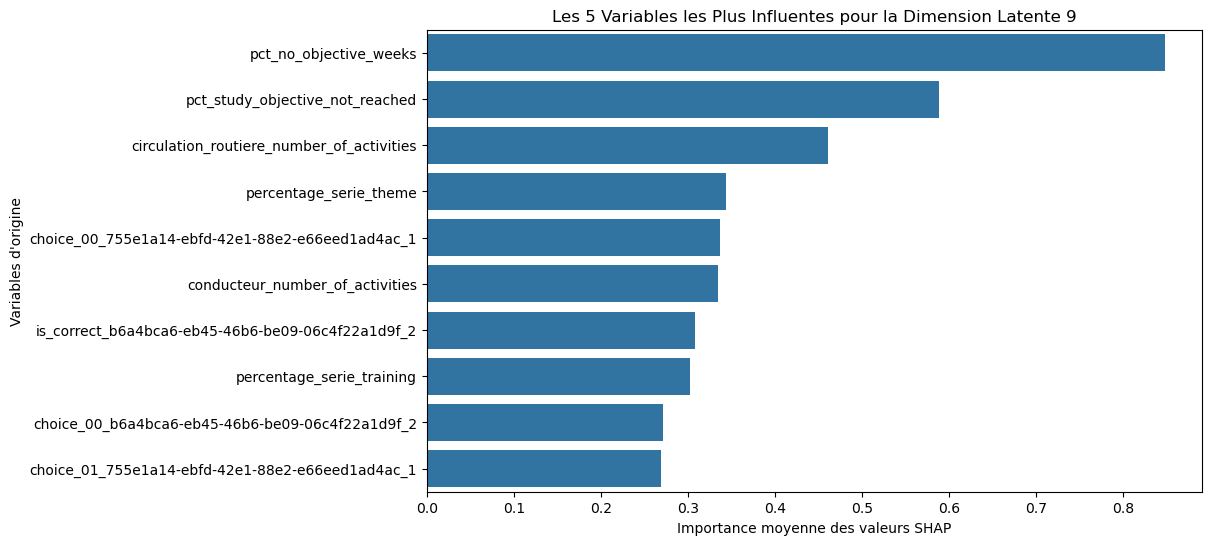

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=8 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette neuvième dimension latente semble être principalement influencée par **l'atteinte des objectifs d’étude et l’implication dans les activités pratiques liées à la conduite**. La forte influence de **pct_no_objective_weeks** et **pct_study_objective_not_reached** suggère que cette dimension capte les difficultés rencontrées par les candidats dans la gestion de leur emploi du temps et la réalisation de leurs objectifs d’étude. De plus, la présence de **circulation_routiere_number_of_activities** et **conducteur_number_of_activities** indique une connexion avec les **activités pratiques en lien avec la conduite**, mettant en évidence l’importance de la pratique dans l’apprentissage. Les variables associées aux **choix dans les tests** et aux **percentages des séries thématiques et d'entraînement** soulignent également le rôle de **l'engagement dans les exercices théoriques et pratiques**.

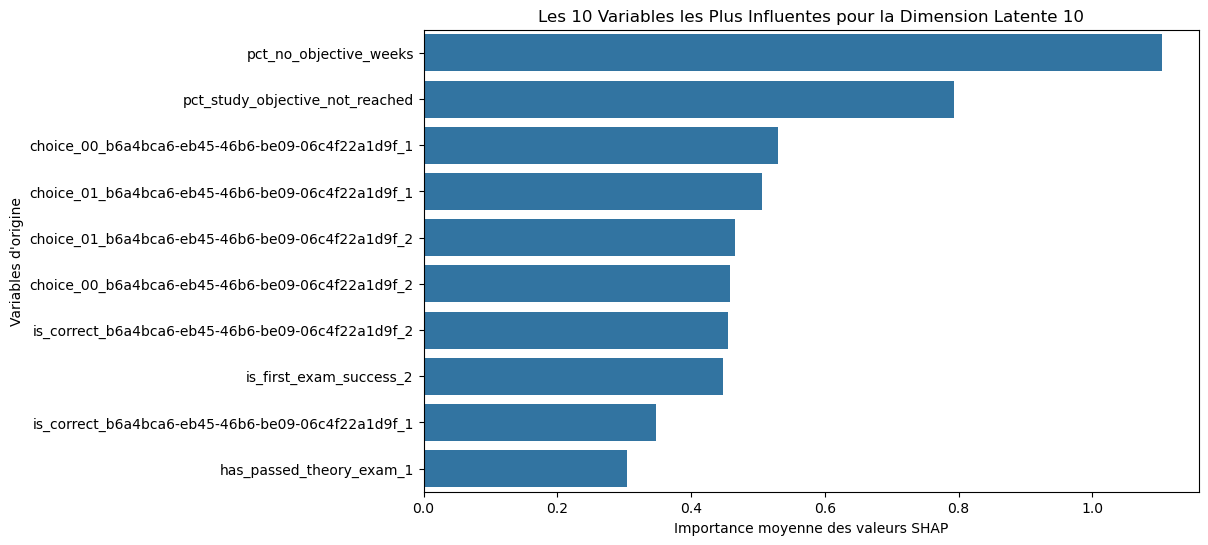

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=9 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


La dixième dimension latente semble être liée à **la gestion du temps d'étude et la performance dans les tests théoriques**, avec une forte influence des variables liées aux **objectifs d’étude non atteints** (pct_no_objective_weeks et pct_study_objective_not_reached), ce qui suggère des difficultés d'organisation ou de progression dans l'apprentissage. Les variables associées aux **choix dans les tests** (choice_00 et choice_01) montrent que cette dimension capte également les aspects liés à **la prise de décisions pendant les évaluations**. La présence de variables telles que **is_correct_b6a4bca6** indique une relation avec **la précision des réponses** dans les tests, ce qui souligne l'importance de la performance théorique. Enfin, l'influence de **is_first_exam_success_2** et **has_passed_theory_exam_1** suggère que cette dimension pourrait être en lien avec **le succès dans les examens théoriques initiaux**, en particulier en ce qui concerne la réussite du premier examen théorique.

In [91]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalisation des données
scaler_X = StandardScaler()
scaler_Z = StandardScaler()

X_scaled = scaler_X.fit_transform(x_test)
Z_scaled = scaler_Z.fit_transform(encoder.predict(x_test))  # Représentations latentes

# Régression Lasso pour identifier les dimensions latentes influentes
lasso = MultiTaskLassoCV(cv=5, random_state=42)
lasso.fit(Z_scaled, X_scaled)

# Importance des dimensions latentes
lasso_coeffs = np.abs(lasso.coef_).sum(axis=0)  # Somme des valeurs absolues des coefficients

# Tri des dimensions les plus influentes
latent_importance = sorted(enumerate(lasso_coeffs), key=lambda x: x[1], reverse=True)

print("Dimensions latentes les plus influentes :")
for i, score in latent_importance:
    print(f"Dimension latente {i+1} : {score:.4f}")


282/282 [==============================] - 0s 2ms/step
Dimensions latentes les plus influentes :
Dimension latente 6 : 274.2841
Dimension latente 8 : 187.0439
Dimension latente 10 : 170.2051
Dimension latente 5 : 99.4518
Dimension latente 7 : 96.9153
Dimension latente 4 : 96.2009
Dimension latente 1 : 75.7487
Dimension latente 3 : 69.1803
Dimension latente 9 : 63.6732
Dimension latente 2 : 44.1513


Le graphique précédent montre l'infleunce de chacune des variables latentes sur la reconstruction. En d'autre terme c'est la part relative d'information contenue par chacune des varibales latentes. On observe que la quantité d'information contenue par les variables 4 et 6 est significativement plus grande que celle portée par les autres variables. 

In [95]:
import numpy as np
from scipy.stats import entropy

# Fonction pour calculer l'entropie empirique
def empirical_entropy(data, bins=50):
    """Calcule l'entropie empirique des données en utilisant un histogramme"""
    data_flat = data.flatten()  # Aplatir les données
    hist, _ = np.histogram(data_flat, bins=bins, density=True)  # Histogramme des fréquences
    hist = hist[hist > 0]  # Éviter les zéros pour éviter log(0)
    
    return entropy(hist)  # Entropie de Shannon

# Calcul des entropies
entropy_original = empirical_entropy(x_test)
entropy_reconstructed = empirical_entropy(decoded_imgs)

print(f"Entropie des données originales : {entropy_original:.4f}")
print(f"Entropie des données reconstruites : {entropy_reconstructed:.4f}")


Entropie des données originales : 1.0443
Entropie des données reconstruites : 2.1333


In [ ]:
from sklearn.feature_selection import mutual_info_regression

# Calculer l'information mutuelle pour chaque variable
mi_values = [mutual_info_regression(x_test[:, i].reshape(-1, 1), decoded_imgs[:, i]) for i in range(x_test.shape[1])]

# Moyenne sur toutes les dimensions
mi_score = np.mean(mi_values)

print(f"Information Mutuelle Moyenne : {mi_score:.4f}")



Information Mutuelle Moyenne : 0.1786
0.6249123184255962


In [99]:
from sklearn.decomposition import PCA

# Étape 1 : Encodage des données
encoded_imgs = encoder.predict(x_test)

# Étape 2 : ACP sur l'espace latent
pca_latent = PCA(n_components=encoded_imgs.shape[1])
pca_latent.fit(encoded_imgs)
variance_expliquee_latent = np.sum(pca_latent.explained_variance_ratio_)

# Étape 3 : ACP sur les données originales
pca_original = PCA(n_components=x_test.shape[1])
pca_original.fit(x_test)
variance_expliquee_original = np.sum(pca_original.explained_variance_ratio_)

# Étape 4 : Calcul du taux d'information conservée
taux_information_acp = (variance_expliquee_latent / variance_expliquee_original) * 100

print(f"Taux d'information conservée selon l'ACP : {taux_information_acp:.2f}%")


282/282 [==============================] - 2s 4ms/step
Taux d'information conservée selon l'ACP : 100.00%
